## Twomey method lab

### Read arcsix data using ict_utils.py

In [1]:
import sys
from pathlib import Path
BASE_DIR = Path.cwd().parent
sys.path.append(str(BASE_DIR / "dev"))

import numpy as np
import pandas as pd

from ict_utils import (read_aps, read_nmass, read_pops, read_uhsas, read_fims, read_inlet_flag,
    check_common_grid, filter_by_spectra_presence, mean_spectrum,)
from sizedist_utils import (edges_from_mids_geometric, dvdlog_from_dndlog, 
    dsdlog_from_dndlog, mids_from_edges, remap_dndlog_by_edges, select_between)

# ============================ CONFIG ============================
start = "2024-06-11 16:00"                                              # Change this
end   = "2024-06-11 16:10"                                              # Change this

DATA_DIR = Path("/Volumes/Hailstone Data/Research Data/ARCSIX_P3B")     # Change this

aps_dir   = DATA_DIR / "LARGE-APS"
nmass_dir = DATA_DIR / "PUTLS-NMASS"
pops_dir  = DATA_DIR / "PUTLS-POPS"
uhsas_dir = DATA_DIR / "PUTLS-UHSAS"
fims_dir  = DATA_DIR / "FIMS"
inlet_dir = DATA_DIR / "LARGE-InletFlag"

OPC_RESPONSE_BINS = 50        # Controls the smoothness of the OPC response functions


# ---------- helpers ----------
def edges_from_meta_or_mids(df: pd.DataFrame, mids_nm: np.ndarray) -> np.ndarray:
    meta = (df.attrs.get("bin_meta") or {})
    lo = meta.get("lower_nm")
    up = meta.get("upper_nm")
    if isinstance(lo, (list, tuple)) and isinstance(up, (list, tuple)) and len(lo) == len(up) and len(lo) > 0:
        return np.r_[np.asarray(lo, float), float(up[-1])]
    return edges_from_mids_geometric(mids_nm)

# ---------- read ----------
aps        = read_aps       (aps_dir,   start=start, end=end, prefix="ARCSIX")
nmass      = read_nmass     (nmass_dir, start=start, end=end, prefix="ARCSIX")
pops       = read_pops      (pops_dir,  start=start, end=end, prefix="ARCSIX")
uhsas      = read_uhsas     (uhsas_dir, start=start, end=end, prefix="ARCSIX")
fims       = read_fims      (fims_dir,  start=start, end=end, prefix="ARCSIX")
inlet_flag = read_inlet_flag(inlet_dir, start=start, end=end, prefix="ARCSIX")

frames = {"APS": aps, "POPS": pops, "UHSAS": uhsas, "FIMS": fims}
_ = check_common_grid(frames, ref_key="FIMS", round_to=None)

# ---------- optional presence filter ----------
fims_qc = pd.to_numeric(fims.get("QC_Flag", pd.Series(index=fims.index)), errors="coerce")
extra = {"FIMS": fims_qc.ne(2)}  # bad=2
filtered, _keep = filter_by_spectra_presence(
    frames, col_prefix="dNdlogDp",
    min_instruments=None,
    extra_masks=extra, treat_nonpositive_as_nan=False
)

# ---------- mean spectra + edges ----------
m_APS,   y_APS,   s_APS,   _ = mean_spectrum(aps,   "APS")
e_APS   = edges_from_meta_or_mids(aps,   m_APS)

m_POPS,  y_POPS,  s_POPS,  _ = mean_spectrum(pops,  "POPS")
e_POPS  = edges_from_meta_or_mids(pops,  m_POPS)

m_UHSAS, y_UHSAS, s_UHSAS, _ = mean_spectrum(uhsas, "UHSAS")
e_UHSAS = edges_from_meta_or_mids(uhsas, m_UHSAS)

m_FIMS,  y_FIMS,  s_FIMS,  _ = mean_spectrum(fims,  "FIMS")
e_FIMS = edges_from_meta_or_mids(fims,  m_FIMS)

# ---------- pack into specs ----------
specs = {
    "APS":   (m_APS,   e_APS,   y_APS,   s_APS),
    #"POPS":  (m_POPS,  e_POPS,  y_POPS,  s_POPS),
    "UHSAS": (m_UHSAS, e_UHSAS, y_UHSAS, s_UHSAS),
    "FIMS":  (m_FIMS,  e_FIMS,  y_FIMS,  s_FIMS),
}

line_kwargs = {
    "_default": {"linewidth": 1.5, 'color':'k'},
    "APS":   {"color":"tab:blue", "alpha":0.6, 'ls':'dashed'},
    #"POPS":  {"color":"tab:orange"},
    "UHSAS": {"color":"tab:green", "alpha":0.6, 'ls':'dashed'},
    "FIMS":  {"color":"tab:red"},
}

fill_kwargs = {
    "_default": {"alpha": 0.1, 'color':'k'},
    #"APS":   {"alpha":0.1,"color":"tab:blue"},
    "APS": False,  # disable fill for APS
    #"POPS":  {"alpha":0.1,"color":"tab:orange"},
    #"UHSAS": {"alpha":0.1,"color":"tab:green"},
    "UHSAS": False,
    "FIMS":  {"alpha":0.1,"color":"tab:red"},
}

### Twomey with K_tophat

In [7]:
#!/usr/bin/env python3
"""
This script retrieves a size distribution n(D) (reported as dN/dlogDp on a global fine grid)
from UHSAS instrument-bin observations using a classic Twomey/Tikhonov inversion.

High-level picture:

We assume the instrument measurements y (counts per UHSAS bin) are related to the unknown
fine-grid spectrum n (dN/dlogDp on the global fine grid) via a linear forward model:

    y  ≈  K  @  n

where:
  - y has length m = number of UHSAS bins (instrument rows),
  - n has length n = number of fine bins (global grid columns),
  - K is an m×n "overlap" kernel that conserves number when integrating over log10(D).

Because inverting K directly is ill-posed/noisy, we solve a *regularized* least-squares problem
(a Twomey/Tikhonov formulation):

    minimize_n   || W ( K n - y ) ||^2   +   λ || L n ||^2
                  data misfit                 smoothness penalty

with:
  - W optional data weights (we set to identity here),
  - λ (lam) the regularization strength,
  - L a discrete derivative operator (order 0/1/2) to enforce smoothness,
  - and optionally n ≥ 0 (nonnegative) enforced via NNLS.

The result is a stabilized estimate n̂ of the fine-grid spectrum that, when forward-modeled
through K, reproduces y within tolerance while avoiding unrealistic oscillations.
"""

import numpy as np

# K_tophat builds the number-conserving overlap matrix K in log10(D) space.
# K[j, i] = overlap length in log10(D) between fine bin i and instrument bin j.
from forward_kernel import K_tophat

# twomey_inversion solves:  y ≈ K n  with Tikhonov/Twomey regularization
# and optional nonnegativity (NNLS on an augmented system).
from twomey_inversion import twomey_inversion


# ============================ CONFIG ============================
# Global fine grid (EDGES, not centers!) in physical diameter [nm].
# We'll use this SAME grid for all instruments in your project; for UHSAS we just
# trim to the overlapping columns so we don't invert unconstrained regions.
fine_edges_nm = np.logspace(1, 4, num=300)   # (N_f+1,) edges spanning 10–10^4 nm

# Inputs coming from your upstream notebook:
#   e_UHSAS : (N_I+1,) UHSAS bin edges [nm]
#   y_UHSAS : (N_I,)   mean UHSAS spectrum in dN/dlogDp units on UHSAS bins
# These are assumed to be already defined above this script in your workflow.


# ============================ KERNEL ============================
# Build the forward kernel from the global fine grid -> UHSAS bins.
# IMPORTANT: K is constructed in log10(D) so that a flat dN/dlogDp integrates to bin width.
#            This makes K number-conserving by construction.
K_full = K_tophat(np.log10(fine_edges_nm), np.log10(e_UHSAS))
# Shapes: K_full.shape = (N_I, N_fine)
#   rows   = instrument bins (UHSAS)
#   cols   = fine bins (global grid)


# ============================ DATA PREP =========================
# Twomey inverts bin *counts* (integrated number per instrument bin), not density.
# Your y_UHSAS is dN/dlogDp on UHSAS bins; convert to counts by multiplying by Δlog10D per bin.
inst_dlog = np.diff(np.log10(e_UHSAS))      # (N_I,) per-UHSAS-bin width in log10 space
y_inst = np.asarray(y_UHSAS, float) * inst_dlog   # (N_I,) counts per UHSAS bin

# Sanity (not required): if you forward a flat spectrum y = 1 on the UHSAS grid,
# counts per bin should equal inst_dlog. This is just to remind ourselves of units.


# ============================ OVERLAP TRIM ======================
# Your global fine grid spans 10–10^4 nm; UHSAS typically covers a subset (e.g., ~60–1000 nm).
# Many fine bins lie outside the UHSAS domain and contribute nothing (unconstrained columns).
# We identify the fine-grid *columns* that overlap ANY UHSAS bin and solve only on those.
col_sums = K_full.sum(axis=0)               # (N_fine,) > 0 means this fine column overlaps UHSAS
idx = np.where(col_sums > 0.0)[0]
i0, i1 = int(idx[0]), int(idx[-1])          # inclusive indices of the overlapping fine-bin range

# Slice the kernel to the overlapping columns only. This keeps the inversion compact and well-posed.
K_use = K_full[:, i0:i1+1]                  # (N_I, N_overlap) kernel restricted to overlap columns

# Also record the overlapping fine-edge array and its per-bin Δlog10D (useful for diagnostics/plots).
fine_edges_use = fine_edges_nm[i0:i1+2]     # edges are one longer than bins → +2
fine_dlog_use  = np.diff(np.log10(fine_edges_use))

print("K_full shape:", K_full.shape, "  (UHSAS rows × full fine columns)")
print("K_use  shape:", K_use.shape,  "  (UHSAS rows × overlapping fine columns)")
print("Overlap fine range [nm]:", float(fine_edges_use[0]), "→", float(fine_edges_use[-1]))


# ============================ ROW SANITIZE ======================
# Twomey solves only for rows (instrument bins) with valid data.
# If y_inst has NaN/inf for some UHSAS bins, we drop those ROWS consistently from K.
valid_rows = np.isfinite(y_inst)            # True where the measurement is finite
K_valid = K_use[valid_rows, :]              # keep only valid rows
y_valid = y_inst[valid_rows]                # corresponding observed counts

print("Rows kept (valid measurements):", int(valid_rows.sum()), "/", K_use.shape[0])
# NOTE: We do *not* drop columns here (other than the overlap trimming above). Dropping rows is fine
# because it's equivalent to telling the solver "we have no data for those instrument bins".
# Twomey still regularizes across the full overlapping fine-domain (columns).


# ============================ TWOMEY INVERSION ==================
# This is the core: solve y_valid ≈ K_valid @ n_use with regularization.
#
# • The objective minimized is:  ||K_valid n_use − y_valid||^2  +  λ ||L n_use||^2
# • L is a finite-difference operator:
#     order=0 → identity (penalize magnitude)
#     order=1 → first derivative (penalize slope; prefer flat n)
#     order=2 → second derivative (penalize curvature; prefer smooth n)
# • "nonneg=True" enforces n_use ≥ 0 via NNLS on an augmented system (adds sqrt(λ) L rows).
#
# Interpretation:
#   - The first term forces the forward-modeled counts (K_valid @ n_use) to match the measured counts y_valid.
#   - The second term suppresses wild oscillations by making n_use *smooth* in log D.
#   - λ controls the trade-off: larger λ → smoother n (but potentially poorer data fit).
#
lam = 1e-2
n_use, info = twomey_inversion(
    K=K_valid,       # (rows: kept UHSAS bins, cols: overlapping fine bins)
    y=y_valid,       # (counts per kept UHSAS bin)
    lam=lam,         # regularization strength
    order=2,         # smoothness order (0/1/2). 2 is common for PSD inversions.
    w=None,          # optional per-row weights (e.g., 1/σ_i). None → all ones.
    nonneg=True      # enforce dN/dlogDp ≥ 0
)
# On return:
#   n_use is (N_overlap,) → the retrieved fine-grid spectrum (dN/dlogDp) on the overlapping columns.
#   info has simple diagnostics from the solver (e.g., residual norm).


# Pad the solution back onto the FULL global fine grid so downstream code can reuse it.
# Outside the overlap region we set zeros (no constraint): if you later invert multiple instruments
# jointly you will fill these regions with their constraints instead.
n_fine = np.zeros(fine_edges_nm.size - 1, float)  # (N_fine,)
n_fine[i0:i1+1] = n_use                           # put the solved spectrum back in place


# ============================ CHECKS ============================
# Forward-predict the instrument counts using the FULL kernel and the padded solution.
# Compare only on the rows that were used in the solve (valid_rows) for a fair residual.
N_inst_pred_full = K_full @ n_fine         # (N_I,)
res = y_valid - N_inst_pred_full[valid_rows]

print("Twomey used λ =", lam)
print("Solver info :", info)
print("||residual||₂:", float(np.linalg.norm(res)))          # overall misfit norm (kept rows)
print("mean|residual|:", float(np.mean(np.abs(res))))        # average absolute misfit (kept rows))

# Optional quick peek at the central part of the retrieved spectrum (purely informational)
center = (i0 + i1) // 2
sl0 = max(i0, center - 5)
sl1 = min(i1 + 1, center + 5)
print(f"n_fine slice [{sl0}:{sl1}] (dN/dlogDp):",
      np.array2string(n_fine[sl0:sl1], precision=4))


# ============================ ADD RETRIEVAL TO SPECS ============================
# We now add the retrieved PSD as a new "instrument" so your existing plotting code can show it.
# We supply mids (centers) computed from the global edges, the edges themselves, the retrieved
# dN/dlogDp vector, and a sigma array (here NaN because we didn't propagate uncertainties yet).
from sizedist_utils import mids_from_edges

m_FINE = mids_from_edges(fine_edges_nm)     # (N_fine,) geometric centers from the edges

# "UHSAS_TWOMEY" is just a label for plotting; it indicates this PSD was inverted from UHSAS data.
specs["UHSAS_TWOMEY"] = (
    m_FINE,                 # mids (nm) on the global grid
    fine_edges_nm,          # edges (nm) on the global grid
    n_fine,                 # retrieved dN/dlogDp (global fine grid, zeros outside overlap)
    np.full(m_FINE.shape, np.nan)  # placeholder uncertainties (not computed here)
)

# Give it a distinctive style so it stands out in your plots.
line_kwargs["UHSAS_TWOMEY"] = {"color": "gray", "linewidth": 2.0}  # bold black
fill_kwargs["UHSAS_TWOMEY"] = False


# ============================ WHAT TWOMEY DID (plain language) ============================
# 1) We built K so each row integrates the fine-grid spectrum over the instrument bin in log-space.
#    If n_fine were exactly correct, K @ n_fine would equal the instrument's counts in each bin.
#
# 2) The direct inverse is ill-conditioned: many n_fine vectors could produce nearly the same y.
#    Twomey adds a smoothness penalty (via L) so among all spectra that fit the data reasonably
#    well, we pick the *smoothest* one consistent with a chosen λ.
#
# 3) We also enforce n_fine ≥ 0 because negative concentrations are unphysical. That's handled by
#    using NNLS on the augmented system [W K; sqrt(λ) L] n ≈ [W y; 0].
#
# 4) Trimming to the overlap region avoids solving for bins that the instrument cannot "see" at all,
#    which improves conditioning and speed and prevents unconstrained oscillations outside the
#    instrument range.
#
# 5) The padded vector n_fine lets you combine multiple instruments on the same global grid later
#    (each instrument constrains a different subset of columns). You can then merge or jointly invert.

K_full shape: (99, 299)   (UHSAS rows × full fine columns)
K_use  shape: (99, 123)   (UHSAS rows × overlapping fine columns)
Overlap fine range [nm]: 59.23457145875806 → 1015.5211276345681
Rows kept (valid measurements): 89 / 99
Twomey used λ = 0.01
Solver info : {'method': 'nnls', 'rnorm': 1.5979371465165708, 'res_norm': 1.5979371465165646}
||residual||₂: 1.318256591827503
mean|residual|: 0.08503239993106006
n_fine slice [133:143] (dN/dlogDp): [257.133  243.8414 230.8688 218.5775 207.1767 196.7078 187.0527 178.0183
 169.4451 161.1732]


### Twomey with K_opc_from_lut

In [5]:
# === NEW: import the OPC kernel builder that uses your optical LUT ===
from forward_kernel import K_opc_from_lut  # uses convert_do_lut under the hood

# ============================ TWOMEY (with OPC LUT kernel) ============================
from twomey_inversion import twomey_inversion
import numpy as np
from pathlib import Path  # <-- NEEDED

# Global fine grid (EDGES) in physical diameter [nm] used for ALL instruments
fine_edges_nm = np.logspace(1, 4, num=100)   # edges, length = N_f+1

# === OPC specifics ===
# Instrument *optical-diameter* edges Do (at calibration RI), σ(D; m) LUT, and your target RI.
# For UHSAS, if you don’t have explicit optical edges, using e_UHSAS here is common.
Do_edges_nm = e_UHSAS

# Refractive indices
RI_SRC = 1.59 + 0.0j   # factory/calibration RI
RI_DST = 1.4 + 0.000j # your particle RI for forward model

# --- Load your σ(D; m) LUT (Zarr) ---
from optical_diameter_core import SigmaLUT

BASE_DIR = Path.cwd().parent
# Make this a PATH/STRING, not a SigmaLUT:
OPC_LUT_ZARR = str(BASE_DIR / "lut" / "uhsas_sigma_col_1054nm.zarr")

# Instantiate ONCE
sigma_lut = SigmaLUT(OPC_LUT_ZARR)

# --- Build the OPC kernel (optical -> physical) via your LUT mapping ---
K_full, mapped_edges_nm = K_opc_from_lut(
    fine_edges_nm=fine_edges_nm,
    Do_edges_nm=Do_edges_nm,
    ri_src=RI_SRC,
    ri_dst=RI_DST,
    lut=sigma_lut,
    response_bins=OPC_RESPONSE_BINS  # assumes this is defined in your session
)

# ========= DATA PREP =========
inst_dlog = np.diff(np.log10(Do_edges_nm))
y_inst = np.asarray(y_UHSAS, float) * inst_dlog             # shape (N_I,)

# ========= OVERLAP TRIM =========
col_sums = K_full.sum(axis=0)
idx = np.where(col_sums > 0.0)[0]
i0, i1 = int(idx[0]), int(idx[-1])

K_use = K_full[:, i0:i1+1]
fine_edges_use = fine_edges_nm[i0:i1+2]
fine_dlog_use  = np.diff(np.log10(fine_edges_use))

# ========= ROW SANITIZE =========
valid_rows = np.isfinite(y_inst)
K_valid = K_use[valid_rows, :]
y_valid = y_inst[valid_rows]

print("K_full shape:", K_full.shape, " (rows=inst bins, cols=fine bins)")
print("mapped_edges_nm range (Dp nm):", float(mapped_edges_nm[0]), "→", float(mapped_edges_nm[-1]))
print("rows kept   :", int(valid_rows.sum()), "/", K_use.shape[0])

# ========= TWOMEY INVERSION =========
lam = 1e-2
n_use, info = twomey_inversion(
    K=K_valid,
    y=y_valid,
    lam=lam,
    order=2,
    w=None,
    nonneg=True
)

# Pad back to the full global fine grid
n_fine = np.zeros(fine_edges_nm.size - 1, float)
n_fine[i0:i1+1] = n_use

# ========= CHECKS =========
N_inst_pred_full = K_full @ n_fine
res = y_valid - N_inst_pred_full[valid_rows]
print("||res||2:", float(np.linalg.norm(res)))
print("mean|res|:", float(np.mean(np.abs(res))))
print("λ used   :", lam)
print("info     :", info)

# ========= ADD TO SPECS FOR PLOTTING =========
m_FINE = mids_from_edges(fine_edges_nm)
specs["UHSAS_TWOMEY"] = (
    m_FINE,
    fine_edges_nm,
    n_fine,
    np.full(m_FINE.shape, np.nan)
)
line_kwargs["UHSAS_TWOMEY"] = {"color": "gray", "linewidth": 2.0}
fill_kwargs["UHSAS_TWOMEY"] = False

K_full shape: (99, 99)  (rows=inst bins, cols=fine bins)
mapped_edges_nm range (Dp nm): 67.04996216598754 → 1381.0212576259034
rows kept   : 89 / 99
||res||2: 2.090581730570002
mean|res|: 0.12550941988202705
λ used   : 0.01
info     : {'method': 'nnls', 'rnorm': 3.028775118241919, 'res_norm': 3.028775118241938}


In [3]:
from optical_diameter_core import SigmaLUT, convert_do_lut, RI_UHSAS_SRC

BASE_DIR = Path.cwd().parent
lut_uhsas = SigmaLUT(str(BASE_DIR / "lut" / "uhsas_sigma_col_1054nm.zarr"))

ri_uhsas = RI_DST
e_uhsas_newdo = convert_do_lut(e_UHSAS, ri_src=RI_UHSAS_SRC, ri_dst=ri_uhsas, lut=lut_uhsas, response_bins=OPC_RESPONSE_BINS)
m_uhsas_newdo = mids_from_edges(e_uhsas_newdo)
y_uhsas_newdo = remap_dndlog_by_edges(e_UHSAS, e_uhsas_newdo, y_UHSAS)
s_uhsas_newdo = remap_dndlog_by_edges(e_UHSAS, e_uhsas_newdo, s_UHSAS)

specs[f'UHSAS RI={ri_uhsas}'] = (m_uhsas_newdo, e_uhsas_newdo, y_uhsas_newdo, s_uhsas_newdo)


### Plot all size distribution in specs

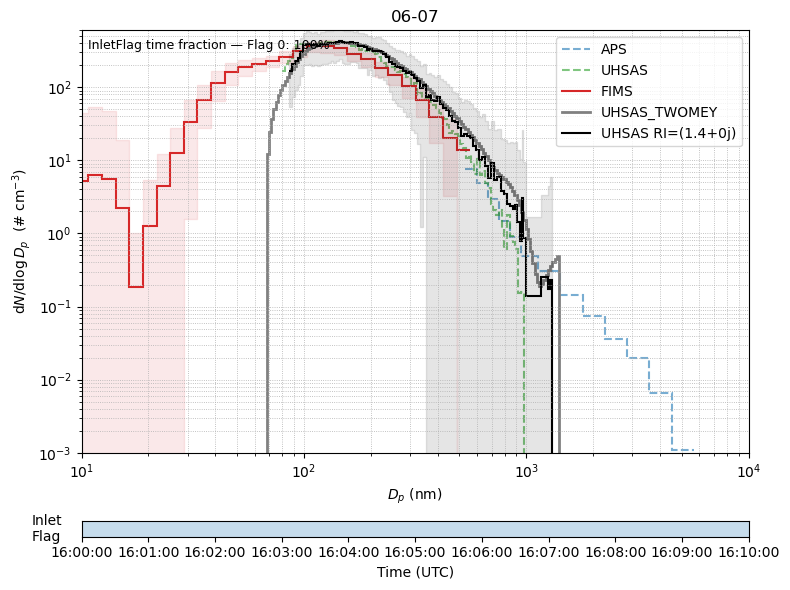

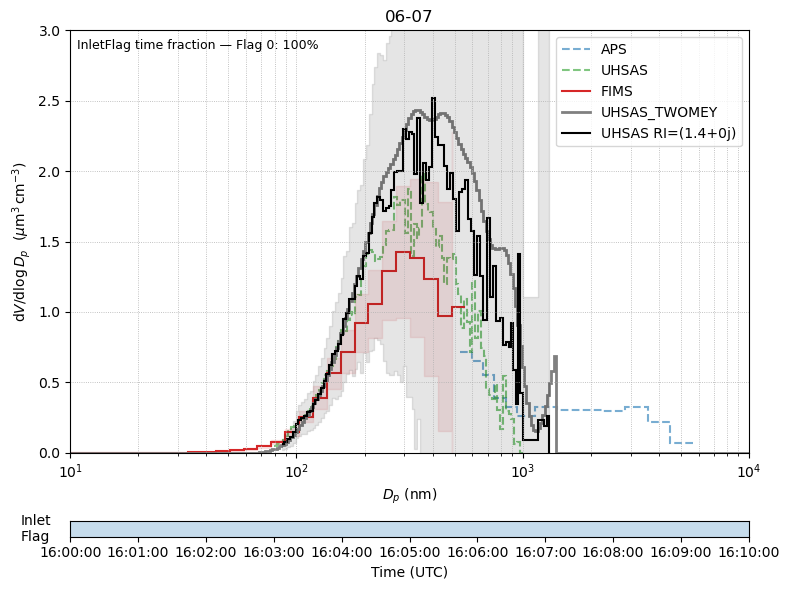

In [4]:
import matplotlib.pyplot as plt
from sizedist_plot import plot_size_distributions, plot_size_distributions_steps

# ============================ PLOT CALL ============================


# --- plot step-style ---
fig, (ax, axf), handles = plot_size_distributions_steps(
    specs=specs,
    inlet_flag=inlet_flag,
    yscale="log",          # or "log"
    xlim=(10, 1e4),
    ylim=(1E-3, 6E2),          
    line_kwargs=line_kwargs,
    fill_kwargs=fill_kwargs,
    show_flag_strip=True,
    moment = 'N',
)

ax.set_title('06-07')
# convert your specs (which are in dN/dlogDp) to dV/dlogDp
specs_V = {
    lab: (mids, edges,
          dvdlog_from_dndlog(mids, vals),
          dvdlog_from_dndlog(mids, sigma))
    for lab, (mids, edges, vals, sigma) in specs.items()
}

# then plot the volume distribution
fig, (ax, axf), handles = plot_size_distributions_steps(
    specs=specs_V,
    inlet_flag=inlet_flag,
    yscale="linear",
    xlim=(10, 1e4),
    ylim=(None, 3),
    line_kwargs=line_kwargs,
    fill_kwargs=fill_kwargs,
    show_flag_strip=True,
    moment = 'V',
)
ax.set_title('06-07')

plt.show()